# The Takeover of Airbnb 
## By Yada Pruksachatkun and Andrea Jackson 

Airbnb, which according to their website is "a peer-to-peer online marketplace and homestay network that enables people to list or rent short-term lodging in residential properties, with the cost of such accommodation set by the property owner," has taken the world by storm. From New York to Australia, it is now possible for backpackers and business people alike to stay in the hospitality of someone else's home. 

We decided to measure how much Airbnb will grow. 

### Framing it as a Bayesian Problem 
We decided to look at how long it would take for a home to get listed in Airbnb, given that another home in the same neighborhood was listed. We defined a neighborhood as an equally sized square blcok, and decided to focus on New York Airbnb listing data. We defined each neighborhood to be 1x1 mile. 

This can be solved using Survival Analysis (Index 1). Survival Analysis is a family of mathematical methods to predict the time until the occurence of an event. 

We decided to use the Weibull distribution. The Probability Distribution Function, or PDF, equation of the weibull is as follows:

In [1]:
from IPython.core.display import Image 
Image(filename='img/pdf.jpg',width=400,height=400)

and the Cumulative Distribution Function (CDF) is as follows:

In [2]:
Image(filename='img/pdf.jpg',width=400,height=400)

In [3]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

import pandas as pd
import pickle

from itertools import product

### Data Source and Assumptions
To calculate the number of living units at a given time t that are listed on Airbnb, we first need to calculate data on each listed living units, including its location in longitude and latitude, zipcode, and date it became listed on Airbnb.

The website [InsideAirbnb.com](http://insideairbnb.com/get-the-data.html) contains csv files of homes listed on Airbnb for cities in the United States. For our project, we decided to analyze the living units listed on Airbnb in New York City. We assume every listing in in the InsideAirbnb data is unique -there exists no listing such that multiple listings are rooms in the same apartment or housing unit.

First, to clean the data, we created a Dataframe from the csv file with latitude, longitude, zipcode, and date listed, storing the dataframe in a Pickle to avoid computational overhead.

For the total number of living units in a neighborhood, we used data from the International Revenue Service (IRS)'s Tax Income SOI csv file, using the number of head of household returns to estimate the number of houses per zipcode. The head of household returns is a fair assumption fo the number of households, and we assume that each household lives in an individual living unit.

Some of the data was formatted incorrectly or were in the zip+4 format, such as 11426-1175. Those zipcodes were replaced with the corresponding zipcode using the  replace_zipcodes function below.

### Extracting the data

In [8]:
df = pd.read_pickle("NYC_listing_pickle")

In [9]:
df.head(15)

,host_since,city,zipcode,latitude,longitude
id,,,,,
3943387,2014-08-23,Bronx,10464,40.839396,-73.781437
6627449,2014-04-04,City Island,10464,40.849775,-73.786609
11675715,2016-01-30,City Island,10464,40.850376,-73.784681
1886820,2013-11-04,Bronx,10464,40.841144,-73.783052
5557381,2015-03-05,Bronx,10464,40.850024,-73.789328
958444,2013-02-24,Bronx,10464,40.852350,-73.788728
8053533,2015-08-25,Bronx,10464,40.848202,-73.789293
9147025,2011-02-21,Bronx,10464,40.844870,-73.789541
7949480,2010-05-06,Bronx,10464,40.852054,-73.788680


Some of the data was formatted incorrectly or were in the zip+4 format, such as 11426-1175. Thus, we replaced those zipcodes with the corresponding zipcode using the function below. 

In [18]:
def replace_zipcodes(zipcodes,newZipcodes):
    '''Input: replaces the zipcode in the dataframe with 
    a new zipcode'''
    for i,z in zip(zipcodes,newZipcodes):
        index = df[df['zipcode'] == i].index.tolist()
        df.set_value(index,'zipcode',z).head(5)

In [19]:
zipcodes = ['11426-1175','10002-2289','10003\n10003','10003-8623','11205-4471',
            '8456422473 call for more details','11103-3233']
newZipcodes = ['11426','10002','10003','10003','11205','10021','11103']
replaceZipcodes(zipcodes,newZipcodes)

### Classifying Living units listed in Airbnb into Neighborhoods
In order to cluster listings into their respective 1x1 mile neighborhoods the location of houses, which is measured by longitude and latitude, must be converted to miles. Using an online calculator, we found the distance between the maximum and minimum longitude in the Airbnb dataset to be 32.64 miles (52.53 km), and 33.64 miles (54.13 km) by latitude.

We decided to divide our grid in the form of a 2D array n_grid , from (0,0) to (32, 33), where each square represents a neighborhood. To map the listed Airbnb listings per square, we created the find_distance function to find which cell in the 2D grid the house will belong to. Given a house x, we found (i,j), the coordinate indices of the cell in n_grid, with the following formula, where $min_{lat} $ and $min_{long} $ represent the minimum longitude and latitude found in the dataset of neighborhoods

$ i =  x_{lat} - min_{lat} $

$ j =  x_{long} - min_{long}$

In [21]:
import geopy

In [22]:
df.zipcode.head(10) # need to count how many zipcodes are NaN

id
3943387     10464
6627449     10464
11675715    10464
1886820     10464
5557381     10464
958444      10464
8053533     10464
9147025     10464
7949480     10464
755528      10467
Name: zipcode, dtype: object

In [23]:
coordinateList = zip(df.latitude, df.longitude, df.zipcode)

In [24]:
''' 
Necessary variables for calculating n_grid and the distance 
between the locaiton of each listed living unit with the minimum
latitude and longitude 
'''

max_lat = df.max(axis=0)['latitude']
max_long =  df.max(axis=0)['longitude']
min_lat = df.min(axis=0)['latitude']
min_long = df.min(axis=0)['longitude']
max_long_row = df.loc[df['longitude']== max_long]
min_long_row = df.loc[df['longitude']== min_long]
max_lat_row = df.loc[df['latitude']== max_lat]
min_lat_row = df.loc[df['latitude']== min_lat]
corresponding_long_of_min_lat = -74.240843
corresponding_lat_of_min_long = 40.499794

We used geopy to calculate the distance betwaeen two latitude, longitude coordinates for each living unit in miles, which will return the neighborhood the living unit is in. 

In [25]:
from geopy import distance

def find_distance(in_lat, in_long):
    '''Paramters: Lat and long of house listing.
       Output: 0 < lat < 33.64 and 0 < long < 32.64
       We calculate the long difference and lat difference by isolating 
       the variables and fixing the other to be the corresponding fixed 
       varaible of the minimum free variable. 
    '''
    diff_long = distance.vincenty((corresponding_lat_of_min_long, in_long), (corresponding_lat_of_min_long, min_long)).miles
    diff_lat = distance.vincenty((in_lat,  corresponding_long_of_min_lat), (min_lat, corresponding_long_of_min_lat)).miles
    return (diff_lat, diff_long)

In [26]:
find_distance(40.783605,-73.967515)

(19.58333832402766, 14.396840047098028)

In [27]:
import math
# n_grid is a dictionary with key: (lat, long) and value : {indices of living unit in neighborhood}
n_grid = {}

# n_grid_zipcodes is a dictionary with key: (zipcodes) and value : {latitude, longitudes corresponding to zipcode}
n_grid_zipcodes = {}

def is_nan(num):
    return num != num

from decimal import *
getcontext().prec = 2

def round_num(x):
    return int(x)

index = 0
for coor in coordinateList:
    latitude,longitude, zipcode = coor
    res_distance = find_distance(latitude,longitude)
    out_distance = (round_num(res_distance[0]), round_num(res_distance[1]))
    # places lat,long values in zipcode grid
    if is_nan(zipcode) is False:
        if type(zipcode) is float:
            zipcode = int(zipcode) 
        zipcode = str(zipcode)
        if n_grid_zipcodes.get(zipcode) is None:
            n_grid_zipcodes[zipcode] = set() 
        n_grid_zipcodes[zipcode].add(out_distance)
        
    # counts the number of neighborhoods per zipcode
    if  n_grid.get(out_distance) is None:
        n_grid[out_distance] = []
    else:
        n_grid[out_distance].append(index)
    index = index + 1

### Classifying total living units into Neighborhoods

Because the number of houses from the IRS are in terms of zipcode, we decided to evenly split the number of houses per latitude and longitude in each zipcode, which we stored in households.CSV.

In [28]:
import csv

# zipcodes_to_num_houses key: zipcode value: number of houses per zipcode
zipcodes_to_num_houses = {}

def represents_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
    
with open('households.csv', 'rb') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        if represents_int(row[1]):  
            zipcodes_to_num_houses[row[0]] = int(row[1])

The birth date of each neighborhood is based on the event of the first listing from each neighborhood. The function below finds the date of the first listing for each neighborhood in n_grid. Based on the birth date of the neighborhood, get_relative_time calculates the time of death for the remaining listings in the neighborhood, storing that data into a dictionary neighborhood_data.

In [29]:
relative_times = {}
import time
from datetime import datetime
        
def findMin():
    '''find the pioneer - the first home in a
    neighborhood to be listed on Airbnb'''
    min_hashmap = {}
    for key, value in n_grid.iteritems():
        if len(value) > 0:
            min_value = time.strftime("%Y-%m-%d")
            for i in range(len(value)):
                host_since = df.iloc[i].host_since
                host_datetime = time.strptime(host_since, "%Y-%m-%d")
                if min_value < host_datetime:
                    min_value = host_since
            min_hashmap[key] = [min_value]
    return min_hashmap

min_hashmap = findMin()    

In [30]:
def get_relative_times():
    '''
    Calculate the age of house listings in neighborhood based on
    pioneer
    '''
    relative_times = {}
    for key, value in n_grid.iteritems():
        if len(value) > 0:
            min_time = min_hashmap[key]
            min_time_l = datetime.strptime(min_time[0],"%Y-%m-%d")
            for i in range(len(value)):
                index = value[i]
                curr_since = df.iloc[index].host_since
                if type(curr_since) is not float:
                    curr_datetime = datetime.strptime(str(curr_since),"%Y-%m-%d")
                    diff = abs((curr_datetime - min_time_l).days) 
                    #diff_months = math.floor(diff/30)
                    if relative_times.get(key) is None:
                        relative_times[key] = [str(diff)]
                    else:
                        relative_times[key].append(str(diff))
    return relative_times

relative_times = get_relative_times()

In [31]:
def prepareData(grid,rel_hash):
    '''
    iterate through each neighborhood in grid and format 
    each listing as (isListed,age).
    isListed: a boolean value
    age: number of days that have passed since pioneer was listed on Airbnb
    
    Return a dictionary where the key is the neighborhood coordinates
    and the value is a list of tuples. Each tuple represents a home in that neighborhood
    '''
    n_dict = {}
    for key, val in grid.iteritems():
        homes = []
        if len(val) > 0:
            listedHomes = rel_hash[key]
            for age in listedHomes:
                f_age = float(age)
                homes.append((True,int(f_age)))
            n_dict[key] = homes
        else:
            pass
    return n_dict
        

In [76]:
neighborhoodData = prepareData(n_grid,relative_times)

### Modeling Survival Analysis using the Weibull Distribution

Using the Weibull Distribution, we model the Weibull Distribution with an Airbnb class, the likelihood of which is calculated by the PDF function (probability distribution of a living unit dying), or 1 - CDF, or the probaiblity distribution of a living unit surviving.
Using this class, we calculate, for each neighborhood, the probability mass function (PMF) for k and lambda. Using the PMF, the k and lambda with the highest probability for each neighborhood can be computed and graphed by graphing the marginal distribution of the PMF. Some of the neighborhoods had a total probability of 0, which we extracted out of dictionar of neighborhoods to PMFs for the sake of simplicity.

In [77]:
# The following Weibull functions were written by Professor Allen Downey, Olin College of Engineering 
def EvalWeibullPdf(x, lam, k):
    """Computes the Weibull PDF.

    x: value
    lam: parameter lambda in events per unit time
    k: parameter

    returns: float probability density
    """
    arg = (x / lam)
    return k / lam * arg**(k-1) * np.exp(-arg**k)

def EvalWeibullCdf(x, lam, k):
    """Evaluates CDF of the Weibull distribution."""
    arg = (x / lam)
    return 1 - np.exp(-arg**k)

def MakeWeibullPmf(lam, k, high, n=200):
    """Makes a PMF discrete approx to a Weibull distribution.

    lam: parameter lambda in events per unit time
    k: parameter
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullPdf(xs, lam, k)
    return Pmf(dict(zip(xs, ps)))

In [78]:
class Airbnb(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        lam,k = hypo
        
        if lam == 0:
            return 0
        
        isListed,age = data
        
        if isListed == True:
            like = EvalWeibullPdf(age, lam, k)
            
        elif isListed == False:
            like = 1 - EvalWeibullCdf(age, lam, k)
            
        else:
            raise ValueError('Invalid data')
            
        return like

In [79]:
# our estimates of k and lambda
lams = np.linspace(0, 5, 101)
ks = np.linspace(0, 5, 101)

def findNeighborhoodPmfs(neighborhood_data):
    '''
    For each neighborhood coordinate in neighborhood data
    the function will find the pmf for each neighborhood.
    fcn returns a dictionary where the key is the neighborhood coordinate
    and value is the pmf
    '''
    pmf_dict = {}
    
    for n_coord,ages in neighborhood_data.iteritems():  
#         print (str(n_coord))
        suite = Airbnb(product(lams,ks))
        data = neighborhood_data[n_coord]

        try:
            suite.UpdateSet(data)
            pmf_dict[n_coord] = (suite)
        
        #if total probability is zero
        except ValueError: 
            pmf_dict[n_coord] = (None)

    return pmf_dict

In [80]:
def MakeWeibullCdf(lam, k, high, n=200):
    """Makes a Cdf approx to a Weibull distribution.
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullCdf(xs, lam, k)
    return Cdf(dict(zip(xs, ps)))

In [81]:
neighborhoodPMF = findNeighborhoodPmfs(neighborhoodData)

In [82]:
# Find the neighborhoods whose total probability was 0 
# and who were assigned None in findNeighborhoodsPmfs
noneList = []
for coord,pmf in neighborhoodPMF.iteritems():
    suite = neighborhoodPMF[coord]
    if suite is None:
        noneList.append(coord)      

The number of neighborhoods in our coordinate system whose calculated total probability was 0.

In [83]:
len(noneList)

55

The total number of neighborhoods in our coordinate system.

In [84]:
len(n_grid)

289

In [85]:
def findValidNeighborhoods(d,noneList):
    '''returns a new dictionary of valid neighborhood coordinates
    as the keys and pmfs as the values'''
    newDict = {}
    for coords, pmf in d.iteritems():
        if coords not in noneList:
            newDict[coords] = pmf
    return newDict

In [86]:
validNeigh = findValidNeighborhoods(neighborhoodPMF,noneList)

After the above calculations, the total number of remaining neighborhoods in our coordinate system is 255. For each coordinate block, we can then calculate the distribution for ks and lambdas for each block.

In [87]:
coordinates = validNeigh.keys()
coordinate_df = pd.DataFrame({'coordinates': coordinates})

In [105]:
coordinate_df.head(20)

,coordinates
0,"(15, 27)"
1,"(6, 9)"
2,"(10, 17)"
3,"(24, 17)"
4,"(17, 20)"
5,"(7, 25)"
6,"(22, 19)"
7,"(15, 23)"
8,"(27, 17)"
9,"(18, 19)"


### Coordinates (28, 18)

Below is the neighborhood at coordinates (28,18) which is 28 miles in latitude and 18 miles in longitude from the minimum latitude and longitude in the state of New York.

In [106]:
suite1 = neighborhoodPMF[(28,18)]
lam1, k1 = suite1.Random()
weibullcdf1 = MakeWeibullCdf(lam1,k1,10)

{'xscale': 'linear', 'yscale': 'linear'}

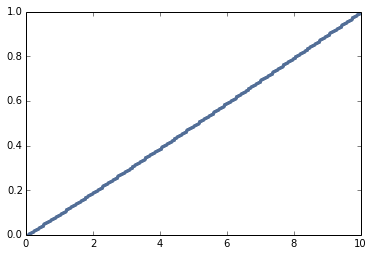

In [107]:
thinkplot.Cdf(weibullcdf1)

The linear relation between the pairs of (k, lambda) show that as time passes, the probability of failure (a house being listed in Airbnb) increases in a linear fashion.

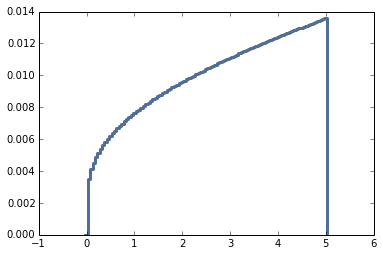

In [108]:
marginalLam1 = suite1.Marginal(0)
thinkplot.Pmf(marginalLam1)

The above marginal PMF graph shows that the maximum probability of lambda is when lambda is 5, meaning that the Weibull PDF plot will be skewed to the right. This means that the probability of dying increases at a faster rate as the time since birth increases.

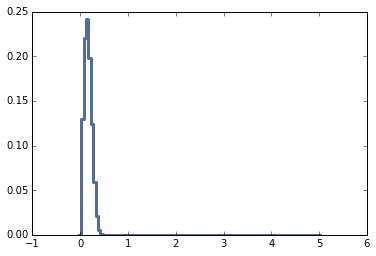

In [109]:
marginalK1 = suite1.Marginal(1)
thinkplot.Pmf(marginalK1)

The above marginal PMF graph shows that the maximum probability of k is when k is 0.3, meaning that the Weibull PDF plot will be skewed to the right. This means that the probability of dying increases at a faster rate as time since birth increases.

### Coordinates (19, 24) 

Below is the neighborhood at coordinates (19,24) which is 19 miles in latitude and 24 miles in longitude from the minimum latitude and longitude in the state of New York.

In [110]:
suite2 = neighborhoodPMF[(19,24)]
lam2, k2 = suite2.Random()
weibullcdf2 = MakeWeibullCdf(lam2,k2,10)

{'xscale': 'linear', 'yscale': 'linear'}

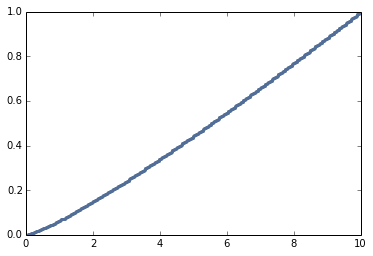

In [111]:
thinkplot.Cdf(weibullcdf2)

Similar to the neghborhood above, the linear relation between the pairs of (k, lambda) show that as time passes, the probability of failure increases in a linear fashion.

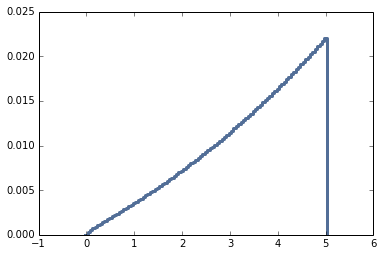

In [112]:
marginalLam2 = suite2.Marginal(0)
thinkplot.Pmf(marginalLam2)

This neighborhood's marginal PMF graph shows that the maximum probability of lambda is when lambda is 5. This means the Weibull PDF plot will also be skewed to the right. The probability of dying increases at a faster rate as the time since birth increases.

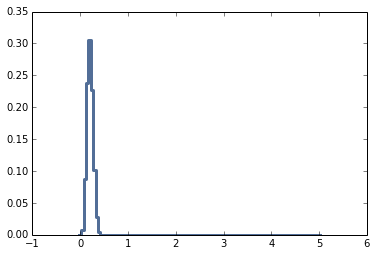

In [113]:
marginalK2 = suite2.Marginal(1)
thinkplot.Pmf(marginalK2)

The above marginal PMF graph shows that the maximum probability of k is when k is 0.4. This means the Weibull PDF plot will be skewed to the right and the probability of dying increases at a faster rate as time since birth increases.

### Coordinates (2, 4)

Below is the neighborhood at coordinates (2,4) which is 2 miles in latitude and 4 miles in longitude from the minimum latitude and longitude in the state of New York.

In [114]:
suite3 = neighborhoodPMF[(2,4)]
lam3, k3 = suite3.Random()
weibullcdf3 = MakeWeibullCdf(lam3,k3,10)

In [115]:
weibullcdf3[1]

0.08388463169771769

{'xscale': 'linear', 'yscale': 'linear'}

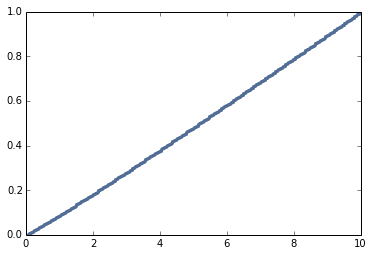

In [116]:
thinkplot.Cdf(weibullcdf3)

This neighborhood's pairs of (k, lambda) show that as time passes, the probability of failure increases in a linear fashion.

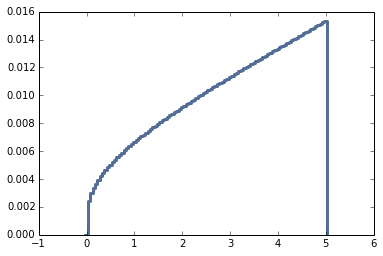

In [117]:
marginalLam3 = suite3.Marginal(0)
thinkplot.Pmf(marginalLam3)

This neighborhood's marginal PMF graph shows that the maximum probability of lambda is when lambda is 5. The Weibull PDF plot will be skewed to the right. The probability of dying increases at a faster rate as the time since birth increases. 

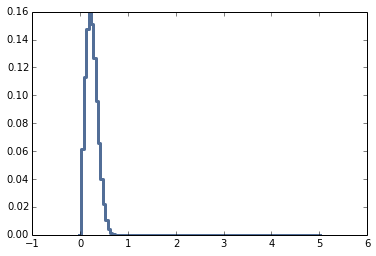

In [118]:
marginalK3 = suite3.Marginal(1)
thinkplot.Pmf(marginalK3)

The above marginal PMF graph shows that the maximum probability of k is when k is 0.5. The Weibull PDF plot will be skewed to the right and the probability of dying increases at a faster rate as time since birth increases.

###  Further Steps 
It is possible to analytically calculate the time (t) in which the failure rate (or the rate at which the probaiblity that another house will be listed on Airbnb) is below 0.01 as a further step. 
To do this, we analytically derived, based on the Hazard function, functions that will calculate the time x such that

In [120]:
import math
from scipy.optimize import minimize_scalar
x_pos = np.linspace(0.0, 1000.0, num=1000)

#We want to find the x that makes the hazard function gets as close to 0.01 as possible. 

def reverse_hazard_function(k, lam):
    def r_h_f(x):
        const = 0.01
        numer = (k * x**(k-1))
        denom = (lam**k)
        exp = math.exp(-((x/lam)**k))
        return (((numer/denom) + const)* exp) - const
    return r_h_f

def not_neg(x):
    return not (x < 0)

def find_min_x(k,lam):
    function = reverse_hazard_function(k, lam)
    res = map(function,x_pos)
    res_d = {}
    for r in range(len(res)):
        res_d[res[r]] = r
    res = filter(not_neg, res)
    min_r =  min(res)
    return res_d[min_r]


### References

https://www.google.com/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=2014+New+York+SOI+Tax+csv

http://insideairbnb.com/get-the-data.html

https://www.wikiwand.com/en/Weibull_distribution

http://mathworld.wolfram.com/HazardFunction.html